
# In-Class Mini Warmups (Slides-Ready)

Each warmup is a short (5–10 min) snippet aligned with the assignments.  
Where plots are involved, **matplotlib** is used (no seaborn styling).  
Some datasets require internet (e.g., `yfinance`, `torchvision`). If offline, see the fallbacks in comments.


## Warmup 1: Moving Average (Noise vs. Signal)

0          NaN
1          NaN
2    12.333333
3    13.333333
4    15.333333
5    17.000000
6    21.000000
dtype: float64


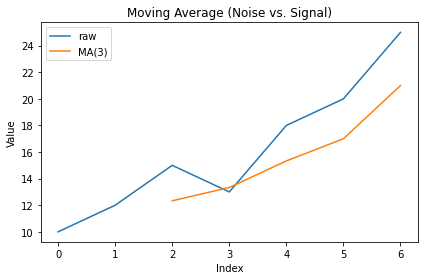

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

data = pd.Series([10,12,15,13,18,20,25])
ma3 = data.rolling(3).mean()
print(ma3)

# Optional plot for slides
plt.figure()
plt.plot(data.values, label="raw")
plt.plot(ma3.values, label="MA(3)")
plt.legend()
plt.title("Moving Average (Noise vs. Signal)")
plt.xlabel("Index"); plt.ylabel("Value")
plt.tight_layout()
# plt.savefig("moving_avg.png", dpi=180, bbox_inches="tight")
plt.show()


## Warmup 2: Coin Flip Simulation

In [2]:

import numpy as np

flips = np.random.choice([0,1], size=10000)
print("Heads proportion:", flips.mean())


Heads proportion: 0.499


## Warmup 3: Hypothesis Test (Two-sample t-test)

In [3]:

from scipy import stats

group1 = [5,6,7,8,9]
group2 = [8,9,10,11,12]
tstat, pval = stats.ttest_ind(group1, group2)
print({"t": tstat, "p": pval})


{'t': -3.0, 'p': 0.017071681233782634}


## Warmup 4: Data Wrangling & Visualization (Titanic Age Histogram)

Could not load Titanic dataset. Fallback: random ages.


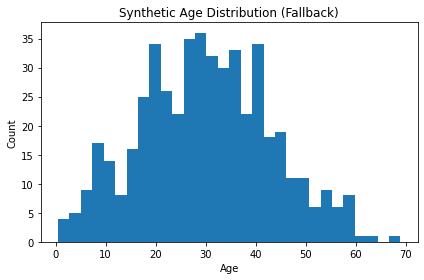

In [4]:

# Uses seaborn only to fetch the Titanic dataset; all plotting via matplotlib.
# If seaborn is unavailable, replace with any numeric Series.
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    titanic = sns.load_dataset("titanic")
    ages = titanic["age"].dropna()
    plt.figure()
    plt.hist(ages, bins=30)
    plt.title("Titanic Passenger Age Distribution")
    plt.xlabel("Age"); plt.ylabel("Count")
    plt.tight_layout()
    # plt.savefig("titanic_age_hist.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    print("Could not load Titanic dataset. Fallback: random ages.")
    import numpy as np, matplotlib.pyplot as plt
    ages = np.random.normal(30, 14, size=500)
    ages = ages[(ages>=0) & (ages<=80)]
    plt.figure()
    plt.hist(ages, bins=30)
    plt.title("Synthetic Age Distribution (Fallback)")
    plt.xlabel("Age"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Warmup 5: Simple Linear Regression

In [5]:

from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array([[1],[2],[3],[4]])
y = np.array([2,4,6,8])
model = LinearRegression().fit(X,y)
print("coef_, intercept_ =", model.coef_, model.intercept_)


coef_, intercept_ = [2.] 0.0


## Warmup 6: k-NN Classifier (Iris)

In [6]:

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

X,y = load_iris(return_X_y=True)
score = KNeighborsClassifier(n_neighbors=3).fit(X,y).score(X,y)
print("Training accuracy:", score)


Training accuracy: 0.96


## Warmup 7: Tiny Perceptron (PyTorch)

In [7]:

# If PyTorch is not installed in your environment, install it or skip this cell.
import torch, torch.nn as nn

model = nn.Sequential(nn.Linear(2,1), nn.Sigmoid())
with torch.no_grad():
    out = model(torch.tensor([[1.0,2.0]]))
print("Output probability:", float(out.item()))


Output probability: 0.49211013317108154


## Warmup 8: CIFAR-10 Sample (with offline fallback)

100%|██████████| 170498071/170498071 [07:00<00:00, 405506.21it/s] 


Extracting ./cifar-10-python.tar.gz to .


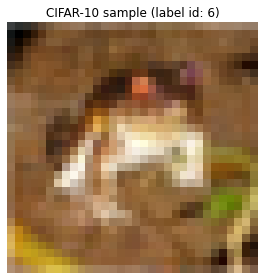

In [8]:

# Requires internet to download CIFAR-10 the first time.
# Fallback: show a digit from sklearn's digits dataset instead.
import matplotlib.pyplot as plt
try:
    import torchvision
    data = torchvision.datasets.CIFAR10(root=".", download=True)
    img, label = data[0]
    plt.figure()
    plt.imshow(img)
    plt.title(f"CIFAR-10 sample (label id: {label})")
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("cifar10_sample.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    from sklearn.datasets import load_digits
    digits = load_digits()
    img, label = digits.images[0], digits.target[0]
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"Digits fallback sample (label: {label})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## Warmup 9: Stock Price Plot (AAPL, with offline fallback)

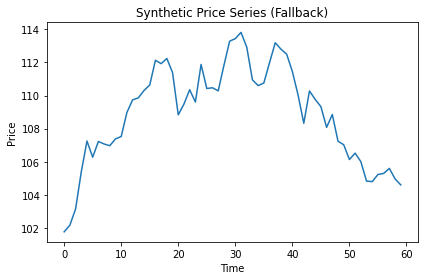

In [10]:

# Requires internet for yfinance. Fallback generates a synthetic random walk.
import matplotlib.pyplot as plt
try:
    import yfinance as yf
    data = yf.download("AAPL", period="1mo", progress=False)
    data["Close"].plot(title="Apple (AAPL) Close - Last Month")
    plt.tight_layout()
    # plt.savefig("aapl_close.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    import numpy as np
    np.random.seed(0)
    steps = np.random.normal(0, 1, 60).cumsum() + 100
    plt.figure()
    plt.plot(steps)
    plt.title("Synthetic Price Series (Fallback)")
    plt.xlabel("Time"); plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


## Warmup 10: PCA on Iris

[[-2.68412563  0.31939725]
 [-2.71414169 -0.17700123]
 [-2.88899057 -0.14494943]
 [-2.74534286 -0.31829898]
 [-2.72871654  0.32675451]]


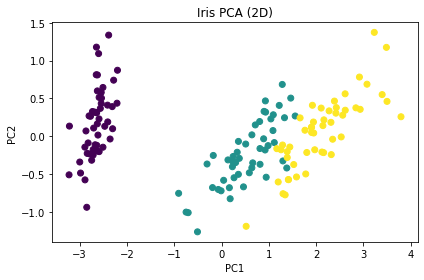

In [11]:

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

X,y = load_iris(return_X_y=True)
X_pca = PCA(n_components=2).fit_transform(X)
print(X_pca[:5])

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title("Iris PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
# plt.savefig("iris_pca.png", dpi=180, bbox_inches="tight")
plt.show()


## Warmup 11: Calibration Curve (Reliability)

True fraction per bin: [0.015 0.375 0.767 0.818 0.971]
Predicted prob per bin: [0.038 0.305 0.502 0.729 0.976]


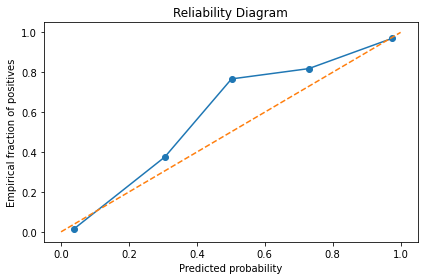

In [12]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import numpy as np

X,y = make_classification(n_samples=1000, random_state=0)
prob = LogisticRegression(max_iter=1000).fit(X,y).predict_proba(X)[:,1]
true_frac, pred_prob = calibration_curve(y, prob, n_bins=5)

print("True fraction per bin:", np.round(true_frac, 3))
print("Predicted prob per bin:", np.round(pred_prob, 3))

# Optional: simple reliability plot (matplotlib)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pred_prob, true_frac, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Reliability Diagram")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical fraction of positives")
plt.tight_layout()
# plt.savefig("reliability.png", dpi=180, bbox_inches="tight")
plt.show()
